In [108]:
import numpy as np
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.layers import Activation, Dense, Dropout, Embedding, add, concatenate, Permute, dot, Input, LSTM
from keras.models import Sequential, Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt

In [2]:
with open('train_qa.txt','rb') as f:
    train_data = load(f)

In [4]:
len(train_data)

10000

In [5]:
with open('test_qa.txt','rb') as f:
    test_data = load(f)

In [6]:
len(test_data)

1000

In [9]:
story, question, answer = train_data[0]

In [11]:
' '.join(story)

'Mary moved to the bathroom . Sandra journeyed to the bedroom .'

In [12]:
' '.join(question)

'Is Sandra in the hallway ?'

In [13]:
' '.join(answer)

'n o'

In [14]:
all_data = train_data + test_data
len(all_data)

11000

In [16]:
vocab = set()

for tup in all_data:
    vocab = vocab.union(tup[0])
    vocab = vocab.union(tup[1])

In [17]:
vocab.add('yes')

In [18]:
vocab.add('no')

In [19]:
vocab

{'.',
 '?',
 'Daniel',
 'Is',
 'John',
 'Mary',
 'Sandra',
 'apple',
 'back',
 'bathroom',
 'bedroom',
 'discarded',
 'down',
 'dropped',
 'football',
 'garden',
 'got',
 'grabbed',
 'hallway',
 'in',
 'journeyed',
 'kitchen',
 'left',
 'milk',
 'moved',
 'no',
 'office',
 'picked',
 'put',
 'the',
 'there',
 'to',
 'took',
 'travelled',
 'up',
 'went',
 'yes'}

In [20]:
len(vocab)

37

In [21]:
vocab_size = len(vocab) + 1

In [23]:
story_lengths = [len(data[0]) for data in all_data]

In [44]:
max_story_len = max(story_lengths)
max_story_len

156

In [26]:
question_lengths = [len(data[1]) for data in all_data]

In [45]:
max_ques_len = max(question_lengths)
max_ques_len

6

In [29]:
tokenizer = Tokenizer(filters=[])
tokenizer.fit_on_texts(vocab)

In [30]:
tokenizer.word_counts

OrderedDict([('apple', 1),
             ('in', 1),
             ('no', 1),
             ('took', 1),
             ('down', 1),
             ('?', 1),
             ('yes', 1),
             ('hallway', 1),
             ('picked', 1),
             ('moved', 1),
             ('is', 1),
             ('john', 1),
             ('football', 1),
             ('put', 1),
             ('office', 1),
             ('to', 1),
             ('journeyed', 1),
             ('.', 1),
             ('bedroom', 1),
             ('went', 1),
             ('dropped', 1),
             ('garden', 1),
             ('grabbed', 1),
             ('left', 1),
             ('bathroom', 1),
             ('got', 1),
             ('mary', 1),
             ('travelled', 1),
             ('daniel', 1),
             ('kitchen', 1),
             ('discarded', 1),
             ('up', 1),
             ('milk', 1),
             ('sandra', 1),
             ('back', 1),
             ('the', 1),
             ('there', 1)])

In [31]:
tokenizer.word_index

{'apple': 1,
 'in': 2,
 'no': 3,
 'took': 4,
 'down': 5,
 '?': 6,
 'yes': 7,
 'hallway': 8,
 'picked': 9,
 'moved': 10,
 'is': 11,
 'john': 12,
 'football': 13,
 'put': 14,
 'office': 15,
 'to': 16,
 'journeyed': 17,
 '.': 18,
 'bedroom': 19,
 'went': 20,
 'dropped': 21,
 'garden': 22,
 'grabbed': 23,
 'left': 24,
 'bathroom': 25,
 'got': 26,
 'mary': 27,
 'travelled': 28,
 'daniel': 29,
 'kitchen': 30,
 'discarded': 31,
 'up': 32,
 'milk': 33,
 'sandra': 34,
 'back': 35,
 'the': 36,
 'there': 37}

In [32]:
tokenizer.index_word

{1: 'apple',
 2: 'in',
 3: 'no',
 4: 'took',
 5: 'down',
 6: '?',
 7: 'yes',
 8: 'hallway',
 9: 'picked',
 10: 'moved',
 11: 'is',
 12: 'john',
 13: 'football',
 14: 'put',
 15: 'office',
 16: 'to',
 17: 'journeyed',
 18: '.',
 19: 'bedroom',
 20: 'went',
 21: 'dropped',
 22: 'garden',
 23: 'grabbed',
 24: 'left',
 25: 'bathroom',
 26: 'got',
 27: 'mary',
 28: 'travelled',
 29: 'daniel',
 30: 'kitchen',
 31: 'discarded',
 32: 'up',
 33: 'milk',
 34: 'sandra',
 35: 'back',
 36: 'the',
 37: 'there'}

In [40]:
train_stories = []
train_questions = []
train_answers = []

for story, ques, ans in train_data:
    train_stories.append(story)
    train_questions.append(ques)
    train_answers.append(ans)

In [41]:
' '.join(train_stories[4])

'Mary moved to the bathroom . Sandra journeyed to the bedroom . Mary went back to the bedroom . Daniel went back to the hallway . Sandra went to the kitchen . Daniel went back to the bathroom . Daniel picked up the football there . Daniel went to the bedroom . John travelled to the office . Sandra went to the garden .'

In [42]:
train_story_seq = tokenizer.texts_to_sequences(train_stories)

In [43]:
len(train_story_seq)

10000

## Text Preprocessing

In [52]:
def vectorize_data(data,word_index=tokenizer.word_index,max_story_len=max_story_len,max_ques_len=max_ques_len):
    # For stories
    X = []
    # For questions
    Q = []
    # For answers
    Y = []
    
    for story, query, answer in data:
        x = [word_index[word.lower()] for word in story]
        q = [word_index[word.lower()] for word in query]
        y = np.zeros(len(word_index) + 1)
        y[word_index[answer]] = 1
        X.append(x)
        Q.append(q)
        Y.append(y)
    
    return (pad_sequences(X,maxlen=max_story_len), pad_sequences(Q,maxlen=max_ques_len), np.array(Y))

In [53]:
train_story_seq, train_query_seq, train_ans_seq = vectorize_data(train_data)

In [54]:
test_story_seq, test_query_seq, test_ans_seq = vectorize_data(test_data)

In [56]:
tokenizer.word_index['yes']

7

In [57]:
tokenizer.word_index['no']

3

In [58]:
sum(test_ans_seq)

array([  0.,   0.,   0., 503.,   0.,   0.,   0., 497.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.])

In [85]:
# INPUT PLACEHOLDERS: (max_length,batch_size) --> batch size is initially unknown so its left empty
input_sequences = Input((max_story_len,))
questions = Input((max_ques_len,))

In [86]:
# INPUT ENCODER M
# Returns (samples,story_len,embedding_dim)
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,output_dim=64))
input_encoder_m.add(Dropout(0.25))

In [87]:
# INPUT ENCODER C
#Returns (samples,story_len,max_question_len)
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,output_dim=max_ques_len))
input_encoder_c.add(Dropout(0.25))

In [88]:
# QUESTION ENCODER
# Returns (samples,embedding_dim,max_question_len)
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,output_dim=64,input_length=max_ques_len))
question_encoder.add(Dropout(0.25))

In [89]:
# ENCODER(INPUT) --> ENCODED
input_encoded_m = input_encoder_m(input_sequences)
input_encoded_c = input_encoder_c(input_sequences)
question_encoded = question_encoder(questions)

In [90]:
match = dot([input_encoded_m,question_encoded],axes=(2,2))
match = Activation('softmax')(match)

In [91]:
# Response o
response = add([match,input_encoded_c])
response = Permute((2,1))(response)

In [92]:
res = concatenate([response,question_encoded])
res

<KerasTensor: shape=(None, 6, 220) dtype=float32 (created by layer 'concatenate_1')>

In [94]:
res = LSTM(50)(res)
res = Dropout(0.3)(res)

In [95]:
res = Dense(vocab_size)(res) # (vocab_size) -> YES/NO 000000 
res = Activation('softmax')(res) 

In [96]:
model = Model([input_sequences,questions],res)

In [97]:
model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics='accuracy')

In [98]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 156)]        0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 6)]          0           []                               
                                                                                                  
 sequential_6 (Sequential)      (None, None, 64)     2432        ['input_9[0][0]']                
                                                                                                  
 sequential_8 (Sequential)      (None, 6, 64)        2432        ['input_10[0][0]']               
                                                                                              

In [107]:
model_checkpoint = ModelCheckpoint(filepath='checkpoint/',monitor='val_accuracy',mode='max',save_best_only=True,verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',mode='max',patience=5,min_lr=0.001,factor=0.1,verbose=1)

r = model.fit([train_story_seq,train_query_seq],
             train_ans_seq,
             batch_size=32,
             epochs=100,
             validation_data=([test_story_seq,test_query_seq],test_ans_seq),
             callbacks=[reduce_lr,model_checkpoint])

Epoch 1/100
313/313 [==============================] - ETA: 0s - loss: 0.2827 - accuracy: 0.8807
Epoch 1: val_accuracy improved from -inf to 0.82900, saving model to checkpoint\


INFO:tensorflow:Assets written to: checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\assets


313/313 [==============================] - 9s 28ms/step - loss: 0.2827 - accuracy: 0.8807 - val_loss: 0.3952 - val_accuracy: 0.8290 - lr: 0.0010
Epoch 2/100
313/313 [==============================] - ETA: 0s - loss: 0.2786 - accuracy: 0.8815
Epoch 2: val_accuracy did not improve from 0.82900
313/313 [==============================] - 4s 13ms/step - loss: 0.2786 - accuracy: 0.8815 - val_loss: 0.4090 - val_accuracy: 0.8240 - lr: 0.0010
Epoch 3/100
310/313 [============================>.] - ETA: 0s - loss: 0.2795 - accuracy: 0.8781
Epoch 3: val_accuracy improved from 0.82900 to 0.83300, saving model to checkpoint\


INFO:tensorflow:Assets written to: checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\assets


313/313 [==============================] - 8s 25ms/step - loss: 0.2802 - accuracy: 0.8777 - val_loss: 0.3935 - val_accuracy: 0.8330 - lr: 0.0010
Epoch 4/100
313/313 [==============================] - ETA: 0s - loss: 0.2799 - accuracy: 0.8812
Epoch 4: val_accuracy improved from 0.83300 to 0.83400, saving model to checkpoint\


INFO:tensorflow:Assets written to: checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\assets


313/313 [==============================] - 9s 28ms/step - loss: 0.2799 - accuracy: 0.8812 - val_loss: 0.4070 - val_accuracy: 0.8340 - lr: 0.0010
Epoch 5/100
311/313 [============================>.] - ETA: 0s - loss: 0.2707 - accuracy: 0.8842
Epoch 5: val_accuracy did not improve from 0.83400
313/313 [==============================] - 4s 14ms/step - loss: 0.2704 - accuracy: 0.8843 - val_loss: 0.4042 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 6/100
311/313 [============================>.] - ETA: 0s - loss: 0.2696 - accuracy: 0.8829
Epoch 6: val_accuracy improved from 0.83400 to 0.84000, saving model to checkpoint\


INFO:tensorflow:Assets written to: checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\assets


313/313 [==============================] - 9s 28ms/step - loss: 0.2695 - accuracy: 0.8828 - val_loss: 0.3975 - val_accuracy: 0.8400 - lr: 0.0010
Epoch 7/100
311/313 [============================>.] - ETA: 0s - loss: 0.2597 - accuracy: 0.8877
Epoch 7: val_accuracy did not improve from 0.84000
313/313 [==============================] - 5s 15ms/step - loss: 0.2599 - accuracy: 0.8875 - val_loss: 0.4132 - val_accuracy: 0.8390 - lr: 0.0010
Epoch 8/100
310/313 [============================>.] - ETA: 0s - loss: 0.2622 - accuracy: 0.8869
Epoch 8: val_accuracy did not improve from 0.84000
313/313 [==============================] - 6s 18ms/step - loss: 0.2634 - accuracy: 0.8864 - val_loss: 0.4167 - val_accuracy: 0.8160 - lr: 0.0010
Epoch 9/100
312/313 [============================>.] - ETA: 0s - loss: 0.2626 - accuracy: 0.8872
Epoch 9: val_accuracy did not improve from 0.84000
313/313 [==============================] - 6s 18ms/step - loss: 0.2623 - accuracy: 0.8874 - val_loss: 0.3887 - val_accura

Epoch 62/100
312/313 [============================>.] - ETA: 0s - loss: 0.1574 - accuracy: 0.9369
Epoch 62: val_accuracy did not improve from 0.84000
313/313 [==============================] - 5s 16ms/step - loss: 0.1572 - accuracy: 0.9370 - val_loss: 0.7203 - val_accuracy: 0.8020 - lr: 0.0010
Epoch 63/100
313/313 [==============================] - ETA: 0s - loss: 0.1479 - accuracy: 0.9384
Epoch 63: val_accuracy did not improve from 0.84000
313/313 [==============================] - 5s 16ms/step - loss: 0.1479 - accuracy: 0.9384 - val_loss: 0.7041 - val_accuracy: 0.8190 - lr: 0.0010
Epoch 64/100
310/313 [============================>.] - ETA: 0s - loss: 0.1465 - accuracy: 0.9411
Epoch 64: val_accuracy did not improve from 0.84000
313/313 [==============================] - 5s 16ms/step - loss: 0.1468 - accuracy: 0.9410 - val_loss: 0.6788 - val_accuracy: 0.8140 - lr: 0.0010
Epoch 65/100
310/313 [============================>.] - ETA: 0s - loss: 0.1503 - accuracy: 0.9411
Epoch 65: val_acc

Epoch 90/100
312/313 [============================>.] - ETA: 0s - loss: 0.1329 - accuracy: 0.9488
Epoch 90: val_accuracy did not improve from 0.84000
313/313 [==============================] - 5s 16ms/step - loss: 0.1328 - accuracy: 0.9488 - val_loss: 0.8091 - val_accuracy: 0.8110 - lr: 0.0010
Epoch 91/100
311/313 [============================>.] - ETA: 0s - loss: 0.1197 - accuracy: 0.9531
Epoch 91: val_accuracy did not improve from 0.84000
313/313 [==============================] - 6s 18ms/step - loss: 0.1197 - accuracy: 0.9531 - val_loss: 0.7946 - val_accuracy: 0.8050 - lr: 0.0010
Epoch 92/100
312/313 [============================>.] - ETA: 0s - loss: 0.1160 - accuracy: 0.9520
Epoch 92: val_accuracy did not improve from 0.84000
313/313 [==============================] - 5s 16ms/step - loss: 0.1160 - accuracy: 0.9520 - val_loss: 0.8361 - val_accuracy: 0.8200 - lr: 0.0010
Epoch 93/100
312/313 [============================>.] - ETA: 0s - loss: 0.1210 - accuracy: 0.9537
Epoch 93: val_acc

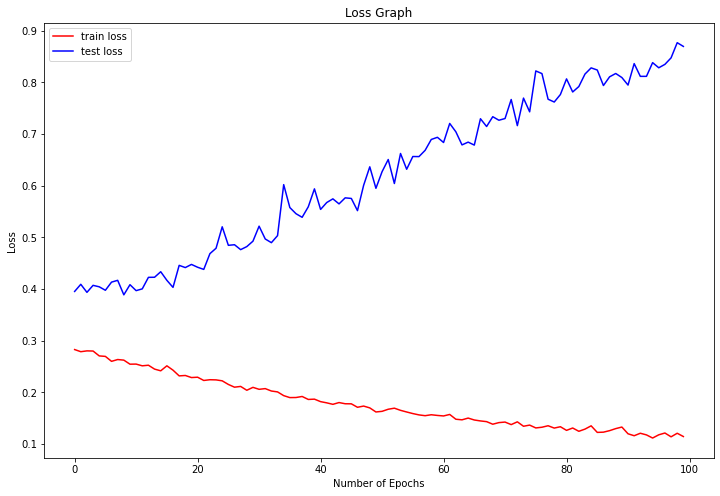

In [109]:
plt.figure(figsize=(12,8))
plt.plot(r.history['loss'],'r',label='train loss')
plt.plot(r.history['val_loss'],'b',label='test loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend();

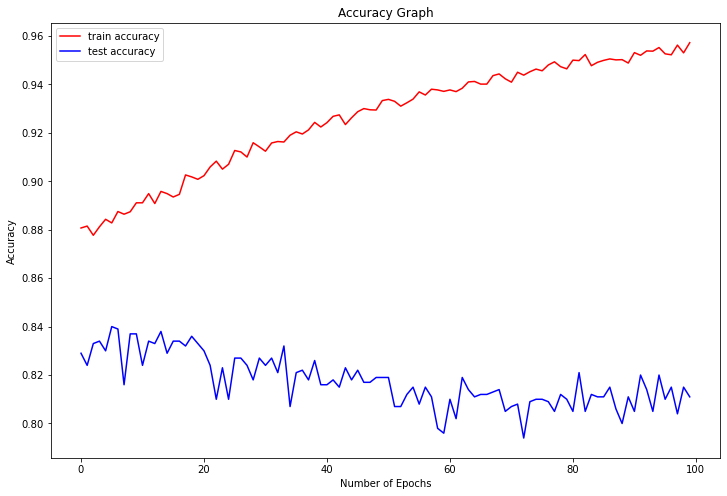

In [110]:
plt.figure(figsize=(12,8))
plt.plot(r.history['accuracy'],'r',label='train accuracy')
plt.plot(r.history['val_accuracy'],'b',label='test accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend();

In [111]:
model.evaluate([test_story_seq,test_query_seq],test_ans_seq)

32/32 [==============================] - 0s 4ms/step - loss: 0.8694 - accuracy: 0.8110


[0.8693567514419556, 0.8109999895095825]

In [112]:
test_pred = model.predict([test_story_seq,test_query_seq])
test_pred

32/32 [==============================] - 2s 5ms/step


array([[4.5076132e-18, 4.4765290e-18, 3.8805615e-18, ..., 4.5259981e-18,
        4.0181725e-18, 3.2544001e-18],
       [6.5020982e-11, 7.4705339e-11, 7.4145190e-11, ..., 8.3273728e-11,
        6.2600827e-11, 6.1732064e-11],
       [1.2476131e-14, 1.2182427e-14, 1.3778931e-14, ..., 1.3435042e-14,
        1.2350716e-14, 1.2657214e-14],
       ...,
       [9.0323625e-13, 9.8838472e-13, 1.0660154e-12, ..., 8.8189216e-13,
        8.2217696e-13, 9.6136521e-13],
       [4.2440292e-12, 4.1301680e-12, 3.9301565e-12, ..., 4.9492212e-12,
        3.9637247e-12, 4.1334544e-12],
       [1.8810586e-18, 2.1030484e-18, 1.7019055e-18, ..., 2.5390164e-18,
        2.4196247e-18, 1.9758272e-18]], dtype=float32)

In [122]:
' '.join(test_data[0][0])

'Mary got the milk there . John moved to the bedroom .'

In [123]:
' '.join(test_data[0][1])

'Is John in the kitchen ?'

In [125]:
test_pred[0]

array([4.5076132e-18, 4.4765290e-18, 3.8805615e-18, 9.9995196e-01,
       3.7784837e-18, 3.7761783e-18, 4.5709020e-18, 4.8009522e-05,
       3.7745943e-18, 3.0026720e-18, 3.9740114e-18, 4.9136551e-18,
       4.2207226e-18, 4.8106823e-18, 3.7410219e-18, 3.5927821e-18,
       3.2902883e-18, 4.4822705e-18, 5.3849553e-18, 4.6706129e-18,
       4.2299580e-18, 3.0556519e-18, 4.4201418e-18, 3.1780662e-18,
       3.2262298e-18, 4.6973970e-18, 4.2836412e-18, 5.0265346e-18,
       3.6117038e-18, 4.2317816e-18, 4.0796750e-18, 4.9648476e-18,
       4.0974081e-18, 3.7614707e-18, 3.7731835e-18, 4.5259981e-18,
       4.0181725e-18, 3.2544001e-18], dtype=float32)

In [116]:
valmax = test_pred[0].argmax()
valmax

3

In [117]:
pred = ''
for key, val in tokenizer.word_index.items():
    if val == valmax:
        pred = key
        break

In [118]:
pred

'no'

In [124]:
test_pred[0][valmax]

0.99995196

In [126]:
vocab

{'.',
 '?',
 'Daniel',
 'Is',
 'John',
 'Mary',
 'Sandra',
 'apple',
 'back',
 'bathroom',
 'bedroom',
 'discarded',
 'down',
 'dropped',
 'football',
 'garden',
 'got',
 'grabbed',
 'hallway',
 'in',
 'journeyed',
 'kitchen',
 'left',
 'milk',
 'moved',
 'no',
 'office',
 'picked',
 'put',
 'the',
 'there',
 'to',
 'took',
 'travelled',
 'up',
 'went',
 'yes'}

In [146]:
mystory = 'Sandra moved to the kitchen . Daniel took football in the garden .'
mystory

'Sandra moved to the kitchen . Daniel took football in the garden .'

In [147]:
myques = 'Is Sandra in the kitchen ?'
myques

'Is Sandra in the kitchen ?'

In [148]:
mydata = [(mystory.split(),myques.split(),'no')]
mydata

[(['Sandra',
   'moved',
   'to',
   'the',
   'kitchen',
   '.',
   'Daniel',
   'took',
   'football',
   'in',
   'the',
   'garden',
   '.'],
  ['Is', 'Sandra', 'in', 'the', 'kitchen', '?'],
  'no')]

In [149]:
my_story_seq, my_ques_seq, my_ans_seq = vectorize_data(mydata)

In [150]:
my_story_pred = model.predict([my_story_seq,my_ques_seq])
my_story_pred

1/1 [==============================] - 0s 21ms/step


array([[1.0500770e-12, 1.1563390e-12, 1.2630450e-12, 1.8422568e-01,
        1.1919444e-12, 1.2069980e-12, 1.1618971e-12, 8.1577432e-01,
        1.1158265e-12, 1.3197698e-12, 1.1435040e-12, 1.1333637e-12,
        1.1924969e-12, 1.3408141e-12, 1.1640311e-12, 1.2083340e-12,
        1.1206682e-12, 1.2291265e-12, 1.2952607e-12, 1.0843755e-12,
        1.2052634e-12, 1.1470253e-12, 1.2860587e-12, 1.0048555e-12,
        1.0284771e-12, 1.1237418e-12, 1.0602080e-12, 1.4113120e-12,
        1.1199417e-12, 1.1359261e-12, 1.2111328e-12, 1.4970248e-12,
        1.1258314e-12, 1.1511106e-12, 1.2759824e-12, 1.3567744e-12,
        1.1522484e-12, 1.0560445e-12]], dtype=float32)

In [151]:
valmax = my_story_pred[0].argmax()
valmax

7

In [152]:
for key, val in tokenizer.word_index.items():
    if val == valmax:
        pred = key
        break

In [153]:
print(pred)

yes


In [154]:
my_story_pred[0][valmax]

0.8157743